In [2]:
import  torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torch.utils.data as td

定义变量

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_works = 4
batch_size = 256
input_dim=100
epochs = 1
print("run on ",device.type)

run on  cpu


In [4]:
from typing import Iterable


# loading data
def loading_minist_data(batch_siz:int, works:int)->(Iterable,Iterable):

    train_set = torchvision.datasets.MNIST(root="./data",train=True,transform=torchvision.transforms.ToTensor(),download=True)
    test_set = torchvision.datasets.MNIST(root="./data",train=False,transform=torchvision.transforms.ToTensor(),download=True)
    return td.DataLoader(dataset=train_set, batch_size=batch_siz, shuffle=True, num_workers=works,drop_last=True), td.DataLoader(dataset=test_set, batch_size=batch_siz, shuffle=True, num_workers=works,drop_last=True)


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # 28*28 -> (28-(5-1))/2 = 12*12
            nn.Conv2d(1, 10,kernel_size=5, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
            # 10 filters to 10 filters
            # 12*12 -> 5*5
            nn.Conv2d(10, 10, kernel_size=3, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
            nn.Linear(250, 10),
            nn.Sigmoid()
        ).to(device)
        self.cnt=0
        self.loss_metric=[]
        self.loss_func = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters())
        pass
    def forward(self,inputs):
        return self.model(inputs)
    def train(self,inputs,targets):
        out = self.forward(inputs)

        loss = self.loss_func(out,targets)
        self.cnt+=1
        self.loss_metric.append(loss.item())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        pass

class Generator(nn.Module):
    def __init__(self,in_dim:int):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 784),
            nn.Sigmoid()
        ).to(device)
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        # counter and accumulator for progress
        self.cnt = 0
        self.loss_metric = []


    def forward(self,inputs):
        return self.model(inputs).view(batch_size,28,28)
    def train(self,D:Discriminator,inputs,targets):
        gen_out = self.forward(inputs)
        # print(gen_out.shape)
        d_out = D.forward(gen_out)

        loss  = D.loss_func(d_out,targets)
                # zero gradients, perform a backward pass, update weights
        self.cnt+=1
        self.loss_metric.append(loss.item())
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

def generate_random_seed(size):
    random_data = torch.randn(size*batch_size).view(batch_size,size)
    return random_data.to(device)


generate nums is run on  cpu


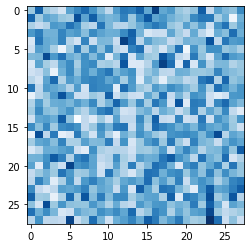

In [11]:
G = Generator(input_dim)

train_iter ,test_iter = loading_minist_data(batch_size,4)
print("generate nums is run on ",generate_random_seed(input_dim).device)

output = G.forward(generate_random_seed(input_dim))
# img = output.detach().numpy().reshape(28,28)
plt.imshow(output.cpu().detach().numpy()[0], interpolation='none', cmap='Blues')

In [18]:
%%time
# train set
temp_epoch = 3
D = Discriminator()
for i in range(temp_epoch):
    print("training ",i+1,"of",temp_epoch)
    for it,label in train_iter:
        label.dtype=torch.float32
        D.train(it,label.view(64,1))

training  1 of 3


AttributeError: attribute 'dtype' of 'torch._C._TensorBase' objects is not writable

In [9]:
%%time
D = Discriminator()
G = Generator(input_dim)
for i in range(epochs):
    print("epoch   ",i)

    for it,_ in train_iter:
        tr_item = it.to(device)
        D.train(tr_item,torch.ones(size=(batch_size,1),dtype=torch.float32).to(device) )

        D.train(G.forward(generate_random_seed(input_dim)).detach()
        ,torch.zeros(size=(batch_size,1),dtype=torch.float32).to(device))
        #
        G.train(D,generate_random_seed(input_dim),torch.ones(size=(batch_size,1),dtype=torch.float32).to(device))
        #
        # break

epoch    0
CPU times: user 42.2 s, sys: 19.2 s, total: 1min 1s
Wall time: 10.3 s


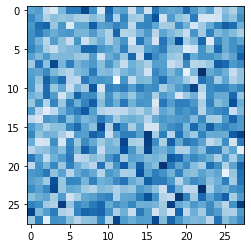

In [8]:
output = G.forward(generate_random_seed(input_dim))
# img = output.detach().numpy().reshape(28,28)
plt.imshow(output.detach().numpy()[0], interpolation='none', cmap='Blues')